In [1]:
import chess
import time
import random
import numpy as np
from tqdm.notebook import trange
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.core.display import clear_output, display
board = chess.Board()

In [3]:
def no_display(x):
    pass

In [4]:
def random_player(board):
    legal_moves = list(board.legal_moves)
    move = random.choice(legal_moves)
    return (move, '')

In [5]:
def human_player(board):
    text = input("Twój ruch: ")
    move = chess.Move.from_uci(text)
    while move not in board.legal_moves:
        display("Ruch {} jest niedozwolony.".format(text))
        text = input("Twój ruch: ")
        move = chess.Move.from_uci(text)
    return (move, '')

In [6]:
"""Funkcja do losowego rozgrywania gry"""
import time
def play(board, max_steps=100,player1=random_player, player2=random_player, interactive=False, summary=True, display=display, clear=True):
    start_time= time.perf_counter()
    players = [player1, player2]
    range_fun = [trange,range][display==no_display] #use trange when in jupyter display mode
    statuses = []
    display(board)
    for turn in range_fun(max_steps):
        if board.is_game_over():
            display("Wyjście po ruchu {}".format(turn))
            break
        for idx in range(len(players)):
            if board.is_game_over():
                break
            player = players[idx]
            (move, status) = player(board)
            board.push(move)
            if (len(status) > 0):
                statuses.append(status)
            if interactive == True:
                if clear==True:
                    clear_output()
                display("Turn {}, Player {}: {}".format(turn, idx, move))
            if interactive == True:
                display(board)
                time.sleep(0.1)
                if clear == True:
                    print('\n'.join(statuses))
    display("Gra zakończona: {}".format(board.is_game_over()))
    if board.is_checkmate():
        winner = {chess.WHITE: 'Czarne', chess.BLACK: 'Białe'}[board.turn] #przegrany ten, którego następna tura
        display("Zwycięzca: {}".format(winner))
    else:
        display("Brak zwycięzcy.")
    display(board)
    end_time = time.perf_counter()-start_time
    if not board.is_checkmate():
        display("Stalemate: {}".format(board.is_stalemate()))
        display("Insufficient_material: {}".format(board.is_insufficient_material()))
        display("Seventyfive_moves rule: {}".format(board.is_seventyfive_moves()))
        display("Fivefold_repetition: {}".format(board.is_fivefold_repetition()))
        display("Variant end condition: {}".format(board.is_variant_end()))
    if board.is_checkmate():
        
        display('time of game {}'.format(end_time))
        result = {chess.WHITE: [0, 1], chess.BLACK: [1, 0]}[board.turn] #przegrany ten, którego następna tura
    else:
        display('time of game {}'.format(end_time))
        result = [0, 0]
    result_dict = {'white_wins' : result[1]
                   , 'black_wins' : result[0]
                   , 'plays' : 1
                   , 'time' : end_time
                  }
    return result_dict
    

In [7]:
#board = chess.Board()
#result = play(board, 100)
#display(result)

In [8]:
def greedy_player(board):
    legal_moves = list(board.legal_moves)
    drops = []
    for idx in range(len(legal_moves)):
        move = legal_moves[idx]
        if board.piece_at(move.to_square):
            drops.append(move)
        if board.is_into_check(move):
            return (move, '')
    if len(drops) > 0:
        move = random.choice(drops)
    else:
        move = random.choice(legal_moves)    
    return (move, '')

In [9]:
import concurrent.futures

        
def mcts_scan_player(board, scans=10, max_depth=20):
    color = board.turn and chess.WHITE
    legal_moves = list(board.legal_moves)
    wins = [0] * len(legal_moves)
    #Definie new funcion
    def mcts_move_search(move):
    #Checks mcts move and then makes a random game. Returns who won '''
        result_for_idx = 0
        for _ in range(scans):
            board_copy = board.copy()
            board_copy.push(move)
            result_dict = play(board_copy, max_steps=20, display=no_display, interactive=False, summary=False)
            #print('thread result ',result)
            result_for_idx += result_dict[{chess.WHITE : 'white_wins', chess.BLACK : 'black_wins'}[color]] 
        #print('End thread result',result_for_idx)
        return result_for_idx
    
    with concurrent.futures.ThreadPoolExecutor() as executor:
        #get result with multithread
        results = executor.map(mcts_move_search, legal_moves)
        temp_ind = 0
        for result in results:
            wins[temp_ind] += result
            temp_ind += 1   
    display(wins)
    
    best = 0
    best_idx = random.randrange(0, len(legal_moves)) #default
    for idx in range(len(legal_moves)):
        if wins[idx] > best:
            best_idx = idx
            best = wins[idx]
    selected = legal_moves[best_idx]
    status = "Selected move: {} at idx {} from assesment {}".format(selected, best_idx, wins)
    #display(status)
    return (selected, status);

In [10]:
def scan_playout(legal_moves, state, scans=10, max_depth=20):
    pass

def random_select_playout(legal_moves, state=None):
    selected_move = random.choice(legal_moves)
    return (selected_move, state)

def weighted_select_playout(legal_moves, tree):
    scores = score(legal_moves, tree)
    scores_np = np.array(scores)
    scores_norm = scores_np / scores_np.sum()
    sample = np.random.multinomial(1, scores_norm)
    idx = np.where(sample==1)[0][0]
    selected_move = legal_moves[idx]
    return (selected_move, None)

def score(legal_moves, tree):
    scores = [0] * len(legal_moves)
    for idx, move in enumerate(legal_moves):
        move = legal_moves[idx]
        if move.uci() in tree:
            summary = tree[move.uci()]
            scores[idx] = 1 + 10 * summary['white_wins']
        else:
            scores[idx] = 1
    return scores

def join_result(node, move, result):
    key = move.uci()
    if not (key in node):
        node[key] = result
        node[key]['move'] = move
    else:
        curr = node[key]
        for attr in ['white_wins', 'black_wins', 'plays']:
            curr[attr] += result[attr]
    return node

def select_best(node):
    best_score = -1
    best_move = None
    for k, v in node.items():
        if v['white_wins'] > best_score:
            best_move = v['move']
            best_score = v['white_wins']
    return best_move

def mcts_tree_player(board, strategy=random_select_playout):
    color = board.turn and chess.WHITE
    legal_moves = list(board.legal_moves)

    root = {}
    
    #playout
    #number_of_plays = 200
    plays_counter = 0
    start_time = time.perf_counter()
    actual_time = 0
    max_time = 3
    while actual_time< max_time :
        plays_counter += 1
        #print(actual_time)
        (playout_next_move, _) = strategy(legal_moves, root)
        board_copy = board.copy()
        board_copy.push(playout_next_move)
        result = play(board_copy, max_steps=20, display=no_display, interactive=False, summary=False)
        join_result(root, playout_next_move, result)
        new_time = time.perf_counter()
        actual_time = new_time-start_time
    
    #state
    #display(root)
    
    #selection
    selected = select_best(root)
    status = "Space {}, plays {}, selected move: {} with state {}".format(len(legal_moves), plays_counter, selected, root[selected.uci()])
    
    display(status)
    
    return (selected, status);

In [11]:
b = chess.Board()
lm = list(b.legal_moves)


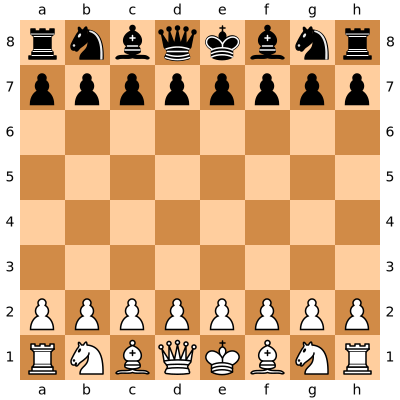

"Space 20, plays 453, selected move: g1f3 with state {'white_wins': 0, 'black_wins': 0, 'plays': 22, 'time': 0.005540400000001, 'move': Move.from_uci('g1f3')}"

In [12]:
board=chess.Board()
display(board)
x = mcts_tree_player(board, strategy=random_select_playout)

In [13]:
#cust_player=(lambda b : mcts_scans_player(b, scans=10, max_depth=20))
#play(chess.Board(), player1=mcts_tree_player, interactive=True, max_steps=100, clear=True)

In [14]:
from src.Chess_q_learning.player_loader import Player_loader as loader
import src.Chess_q_learning.EpsilonGreedyStrategy as epsilonStr
from src.Chess_q_learning.ChessEnv import ChessEnv

In [15]:
env = ChessEnv()
PATH = 'C:\Studia\WZSI\wzsi2-blonski-maternik\src\Chess_q_learning\chessLearned10000.2.pt'

In [16]:
load = loader()
agent = load.load_NN(PATH,env)

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Studia\\WZSI\\wzsi2-blonski-maternik\\src\\Chess_q_learning\\chessLearned10000.2.pt'

In [17]:
def agent_player(board):
    legal_moves = list(board.legal_moves)
    state = env.state()
    action = agent.select_action_game(state)
    move = legal_moves[action]
    return (move, '')

In [18]:
#cust_player=(lambda b : mcts_scans_player(b, scans=10, max_depth=20))
#play(env.board, player1=agent_player,player2=human_player, interactive=True, max_steps=100, clear=True)

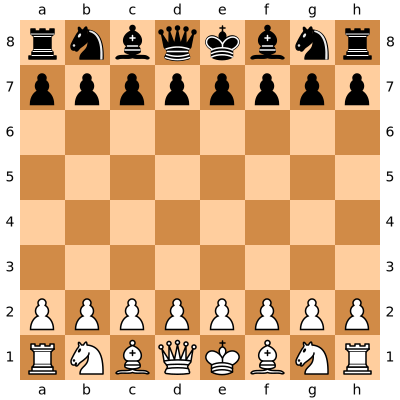

NameError: name 'agent' is not defined

In [19]:
#cust_player=(lambda b : mcts_scans_player(b, scans=10, max_depth=20))
env.reset()
play(env.board, player1=agent_player,player2=random_player, interactive=True, max_steps=256, clear=True)

In [ ]:
env.reset()
cust_player=(lambda b : mcts_scan_player(b, scans=10, max_depth=20))
play(env.board, player1=cust_player,player2=agent_player, interactive=True, max_steps=100, clear=True)

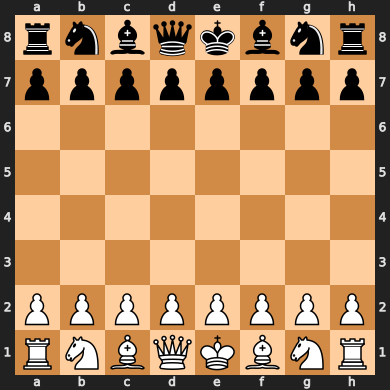

In [45]:
env.reset()
env.board
x = random_player(env.board)
env.board

In [46]:
x

(Move.from_uci('b2b4'), '')

'Turn 34, Player 1: e5g3'

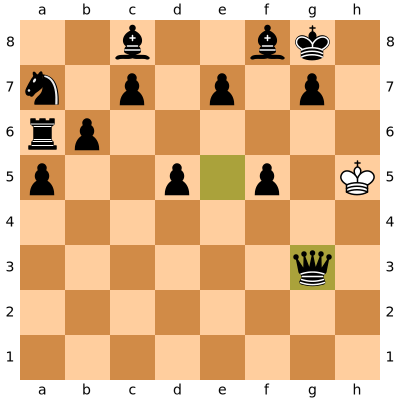

'Wyjście po ruchu 35'

'Gra zakończona: True'

'Brak zwycięzcy.'

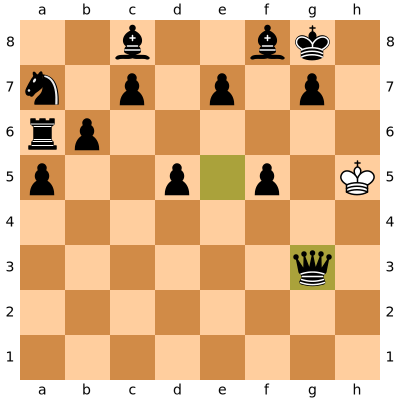

'Stalemate: True'

'Insufficient_material: False'

'Seventyfive_moves rule: False'

'Fivefold_repetition: False'

'Variant end condition: False'

'time of game 8.014199299999746'

{'white_wins': 0, 'black_wins': 0, 'plays': 1, 'time': 8.014199299999746}

In [51]:
from src.Players.Agent_Player import AgentPlayer
board = chess.Board()
player2 = greedy_player
#player1 = cust_player = (lambda b: mcts_q_player(b, move_time_limit=8))
agent_player = AgentPlayer(ChessEnv(), PATH='src\Chess_q_learning\chessLearned5000.99.pt')
custom_player = (lambda b: agent_player.agent_player(b))
play(board, player1=custom_player, player2=player2, interactive=True, max_steps=100, clear=True)
#play(board, player1=custom_player, player2=player2, interactive=True, max_steps=100, clear=False)